In [7]:
# *** NOTE: Due to tuning and large search space, running this notebook may take considerable time. final models are saved as pickle files ***
import os
import pickle
from tqdm import tqdm # progress bar

import pandas as pd
import numpy as np
import time, copy

# visuals.
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# models
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV # hyper-parameters tuning
from sklearn.preprocessing import MinMaxScaler

# metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# constant seed for reproducibility
SEED = 111 
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)

# cpu workers
WORKERS = -1

In [4]:
# functions:
def modelEvaluation(y_val, preds):
    """ 
    Calculates certain metrics of a predictions series
    
    """
    mse = mean_squared_error(y_val, preds)
    mae = mean_absolute_error(y_val, preds)
    r2 = r2_score(y_val,preds) 
    return mse,mae,r2

def measureParams(model, paramsDict):
    
    """
    measures set of performances of a model over a range of controlled
    parameter configurations
    Inputs: 
        Model - SKlearn model object
        paramsDict - Dictionary of input parameters
        
    Output:
        Nested Dictionary of results
    """
    
    results = []
    metric_list = ["MSE","MAE","R2","Time"]
    Ys_init = {}
    for i in metric_list:
        Ys_init[i] = []
    
    for k in tqdm(paramsDict.keys()):
        Xs = []
        Ys = copy.deepcopy(Ys_init)
        for v in paramsDict[k]:
            Xs.append(v)
            reg = model()
            params = {k:v}
            reg.set_params(**params)
            start_time = time.time() # Start timer
            reg.fit(X_train, y_train)
            delta = time.time() - start_time # Training time
            preds = reg.predict(X_val)
            mse,mae,r2 = modelEvaluation(y_val,preds)
            Ys['MSE'].append(mse)
            Ys['MAE'].append(mae)
            Ys['R2'].append(r2)
            Ys['Time'].append(delta)
        result = {
            "title":f"{k}_plot",
            "Xs":Xs,
            "Ys":Ys
        }
        results.append(result)
    return results

def dictionaryLists(model, base_model, parameter, increments):
    """
    Function to create a list of dictionaries as input to arguments of a calibrated 
    model to further tune it using validation set.
    
    
    Inputs:
        param_dictionary = param dictionary obtained from random search
        
        parameter = string value of the parameter to be varied
        
        increments = Multiplicative to change parameter by
        
    Returns: 
        List of dictionaries
    
    """
    print(model.best_params_)
    dict_init = model.best_params_
    params_list = []
    for i in increments:
        copy_dict = dict_init.copy()
        copy_dict[f'{parameter}'] =  copy_dict[f'{parameter}'] * i
        params_list.extend([copy_dict])  
        
    results = tune_params(
    base_model, # sklean model object without initialising i.e: without ()
    params_list,
    parameter)
    return results


def tune_params(model, dict_list, control_param):
    
    """
    Measures set of performances of a model over a range of controlled
    parameter configurations. Note that functionally is the same as measure
    Params function, however its intended purpose is for after a random search,
    to further configure parameters defined by the gridsearch. Only control_param 
    is modified and measured, all others are fixed.
    
    Inputs: 
        Model - SKlearn model object
        dict_list - List of Dictionaries
        control_param - Parameter of interest
        
    Output:
        Nested Dictionary of results
    """

    results = []
    metric_list = ["MSE","MAE","R2","Time"]
    Ys_init = {}
    for i in metric_list:
        Ys_init[i] = [] 
        
    for paramsDict in dict_list:
        Xs = []
        Ys = copy.deepcopy(Ys_init)
        reg = model()
        params = paramsDict
        reg.set_params(**params)
        start_time = time.time() # Start timer
        reg.fit(X_train, y_train)
        delta = time.time() - start_time # Training time
        preds = reg.predict(X_val)
        mse,mae,r2 = modelEvaluation(y_val,preds)
        Ys['MSE'].append(mse)
        Ys['MAE'].append(mae)
        Ys['R2'].append(r2)
        Ys['Time'].append(delta)
        result = {
            "Xs":paramsDict[f'{control_param}'],
            "Ys":Ys
        }
        results.append(result)
    return results

    
def plot_paramtuned(results, parameter_name, increments,metrics):  
    fig, axs = plt.subplots(len(metrics), figsize = (10,10))
    
    for metric_idx in range(len(metrics)):
        Xs = []
        Ys = []
        for i in range(len(increments)):
            x = results[i]['Xs']
            y = results[i]['Ys'][f'{metrics[metric_idx]}']
            Xs.extend([x])
            Ys.extend([y])
        axs[metric_idx].plot(Xs,Ys,)
        axs[metric_idx].set_title('Variation in ' + f'{parameter_name}' + " from random search baseline")
        axs[metric_idx].set_xlabel(f'{parameter_name}')
        axs[metric_idx].set_ylabel(f'{metrics[metric_idx]}')
    


In [14]:
# read generated processed pickle files
modeling_data = {
    "X_train":None, # using scaled features only for neural network 
    "X_val":None,
    "y_train":None,
    "y_val":None
}
for k in modeling_data.keys():
    with open(f'./modeling_data/{k}.pickle', 'rb') as handle:
        modeling_data[k] = pickle.load(handle)

X_train = modeling_data["X_train"]
X_val = modeling_data["X_val"]
y_train = modeling_data["y_train"]
y_val = modeling_data["y_val"]

# scale data only for MLP
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# save scaler
with open(f"./models/scaler_mlp.pickle", 'wb') as handle:
    pickle.dump(scaler, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# initialise model
model_obj = {
    "name":"MLP", # sklean model object without initialising i.e: without ()
    "alg":MLPRegressor
}

In [15]:
models_perfs = [] #list of dictionaries of models' performances

model = model_obj["alg"](random_state=SEED) # basic model with default params.
model = model.fit(X_train, y_train)

# evaluation
preds = model.predict(X_val)
mse, mae, r2 = modelEvaluation(y_val, preds)
models_perfs.append({
    "model":f"Basic {model_obj['name']}",
    "MSE":mse,
    "MAE":mae,
    "R-Squared":r2
})
print("Basic Model's Performance")
print("MSE: ", mse)
print("MAE: ", mae)
print("R-Squared: ", r2)

# save basic model
with open(f"./models/{model_obj['name']}_basic.pickle", 'wb') as handle:
    pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)

Basic Model's Performance
MSE:  0.032062529408529473
MAE:  0.1268670266772422
R-Squared:  0.7199082247150907


In [ ]:
# determining optimal range for tuning search space:
results = measureParams(
    model_obj["alg"],
    
    # a dictionary with keys being parameters of the model. NOTE: only numeric parameters can be plotted
    # and values being the range of that parameter to evaluate as a list. NOTE: In ascending order
    {
        "hidden_layer_sizes":[100, 250, 500, 1000],
         "alpha":[1, 0.0505, 0.0001],
         "epsilon":[1, 1e-2, 1e-4],
        "learning_rate_init": [0.01,0.001,0.0001],
         "activation": ['relu','logistic']
    }
)

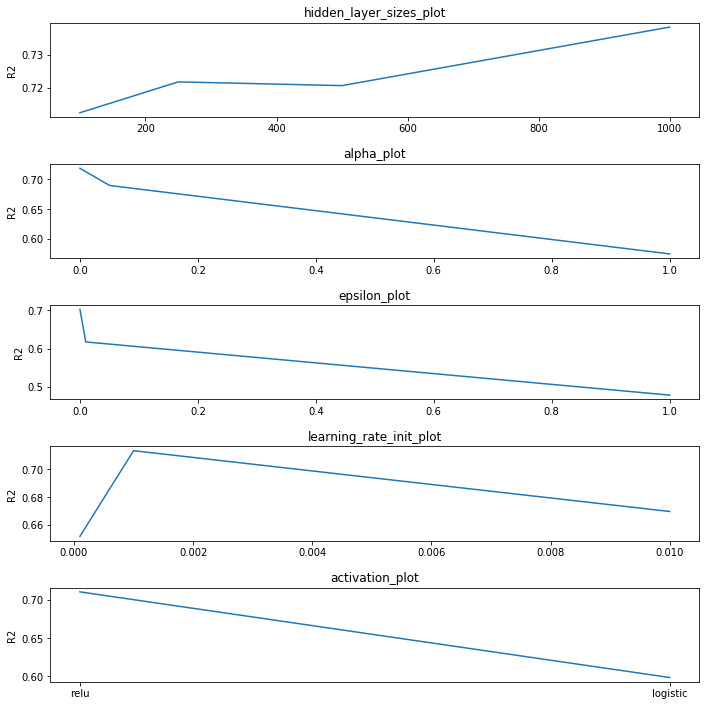

In [31]:
fig, axs = plt.subplots(len(results), figsize = (10,10))

for i in range(len(results)):
    axs[i].plot(results[i]["Xs"], results[i]["Ys"]['R2'])
    axs[i].set_title(results[i]["title"])
    axs[i].set_ylabel('R2')

fig.tight_layout()
fig.tight_layout(pad=1.4)

In [5]:
# Hyper-Parameters tuning via Random Search:
alg = model_obj["alg"](random_state=SEED)
params = {
    "hidden_layer_sizes":[300,550],
    "alpha":[0.00001, 0.00025, 0.005],
    "epsilon":[1e-2,1e-5,1e-7],
    "activation":['relu'],
    "alpha":[0.001],
    "power_t":[0.1],
    "max_iter":[3700]
}

tuning = RandomizedSearchCV(alg, params, random_state=SEED, n_iter=10, cv=3, n_jobs = -1) # 3-fold cross validation
model_tuned = tuning.fit(X_train, y_train) # fits the best performing model

# save tuned model
with open(f"./models/{model_obj['name']}_tuned.pickle", 'wb') as handle:
    pickle.dump(model_tuned, handle, protocol=pickle.HIGHEST_PROTOCOL)

C:\Users\dosti\Anaconda3\envs\mdldm2\lib\site-packages\sklearn\model_selection\_search.py:277: UserWarning:

The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.



In [6]:
with open(f'./models/{model_obj["name"]}_tuned.pickle', 'rb') as handle:
    model_tuned = pickle.load(handle)

print("Tuned Model's Performance")
print(model_tuned.best_params_)
tuned_preds = model_tuned.predict(X_val)
mse, mae, r2 = modelEvaluation(y_val, tuned_preds)
models_perfs.append({
    "model":f"Tuned {model_obj['name']}",
    "MSE":mse,
    "MAE":mae,
    "R-Squared":r2
})
print("Tuned Model's Performance")
print("MSE: ", mse)
print("MAE: ", mae)
print("R-Squared: ", r2)
model_tuned.best_score_ # best score on cross-validation

Tuned Model's Performance
{'power_t': 0.1, 'max_iter': 3700, 'hidden_layer_sizes': 550, 'epsilon': 1e-07, 'alpha': 0.001, 'activation': 'relu'}
MSE:  0.030771524667858145
MAE:  0.12273646660117417
R-Squared:  0.7311861811454301


0.7146066934007722

In [8]:
tuned_preds = model_tuned.predict(X_train)
mse_train, mae_train, r2_train = modelEvaluation(y_train, tuned_preds)
print("MSE: ", mse_train)
print("MAE: ", mae_train)
print("R-Squared: ", r2_train)
model_tuned.best_score_ # best score on cross-validation

MSE:  0.028234479775165886
MAE:  0.1187916891757076
R-Squared:  0.7532369676546569


0.7146066934007722

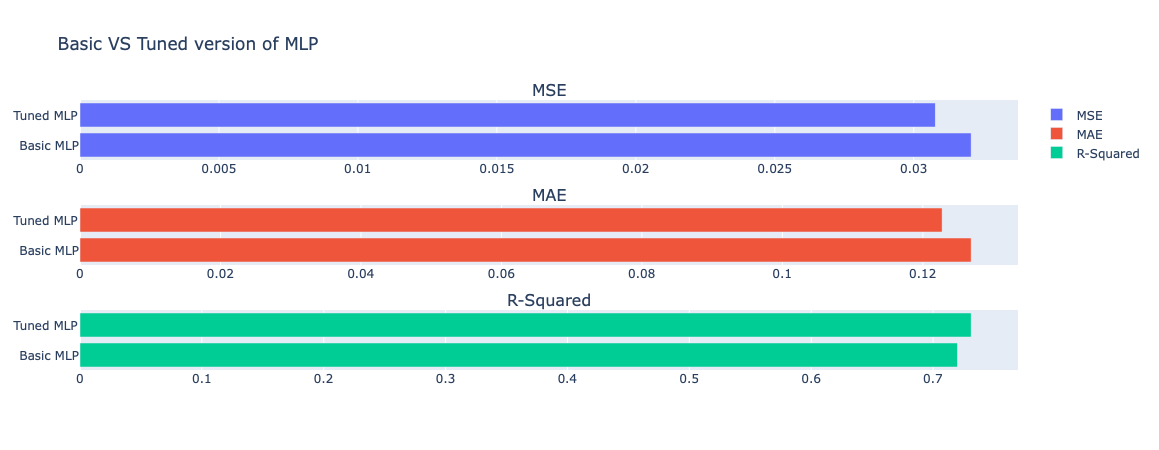

In [9]:
models_perf_df = pd.DataFrame(models_perfs)

fig = make_subplots(rows=3, cols=1, subplot_titles=["MSE", "MAE", "R-Squared"])

fig.add_trace(go.Bar(y=models_perf_df["model"], x=models_perf_df["MSE"], orientation='h', name="MSE"), row=1, col=1)
fig.add_trace(go.Bar(y=models_perf_df["model"], x=models_perf_df["MAE"], orientation='h', name="MAE"), row=2, col=1)
fig.add_trace(go.Bar(y=models_perf_df["model"], x=models_perf_df["R-Squared"], orientation='h', name="R-Squared"), row=3, col=1)
# fig.update_xaxes(range=[0.028, 0.033], row=1, col=1)
# fig.update_xaxes(range=[0.11, 0.13], row=2, col=1)
# fig.update_xaxes(range=[0.7, 0.73], row=3, col=1)

fig.update_layout(title=f'Basic VS Tuned version of {model_obj["name"]}')
fig.show()

{'power_t': 0.1, 'max_iter': 3700, 'hidden_layer_sizes': 550, 'epsilon': 1e-07, 'alpha': 0.001, 'activation': 'relu'}


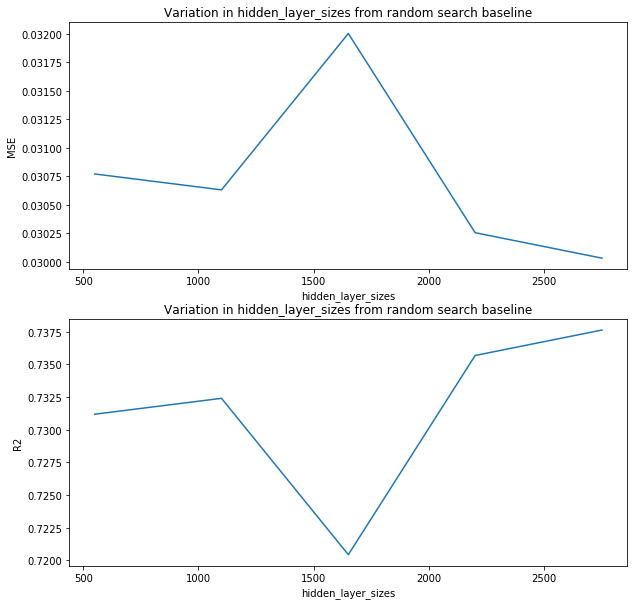

In [10]:
results = dictionaryLists(model_tuned, base_model = model_obj["alg"], parameter='hidden_layer_sizes', increments=[1, 2, 3, 4, 5])
plot_paramtuned(results, 'hidden_layer_sizes' ,[1, 2, 3, 4, 5], metrics = ['MSE','R2'])


{'power_t': 0.1, 'max_iter': 3700, 'hidden_layer_sizes': 550, 'epsilon': 1e-07, 'alpha': 0.001, 'activation': 'relu'}


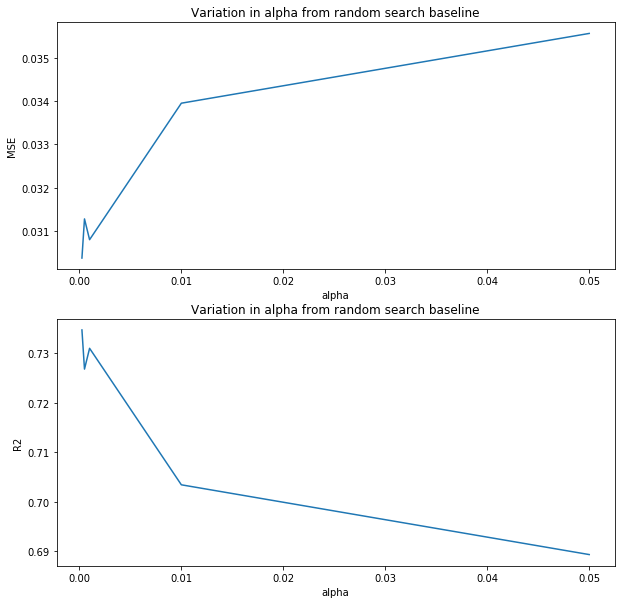

In [11]:
results3 = dictionaryLists(model_tuned, base_model = model_obj["alg"], parameter='alpha', increments=[0.25 , 0.5 ,1, 10, 50])
plot_paramtuned(results3, 'alpha' ,[0.25 , 0.5 ,1, 10, 50], metrics = ['MSE','R2'])


{'power_t': 0.1, 'max_iter': 3700, 'hidden_layer_sizes': 550, 'epsilon': 1e-07, 'alpha': 0.001, 'activation': 'relu'}


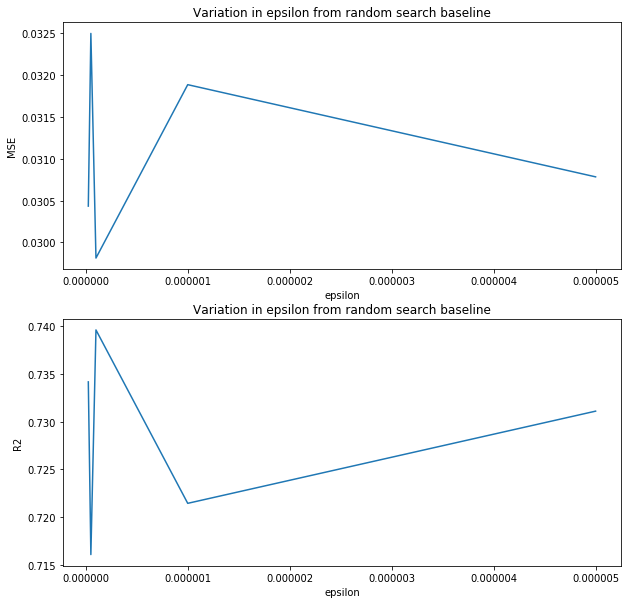

In [12]:
results4 = dictionaryLists(model_tuned, base_model = model_obj["alg"], parameter='epsilon', increments=[0.25 , 0.5 ,1, 10, 50])
plot_paramtuned(results4, 'epsilon' ,[0.25 , 0.5 ,1, 10, 50], metrics = ['MSE','R2'])


{'power_t': 0.1, 'max_iter': 3700, 'hidden_layer_sizes': 550, 'epsilon': 1e-07, 'alpha': 0.001, 'activation': 'relu'}


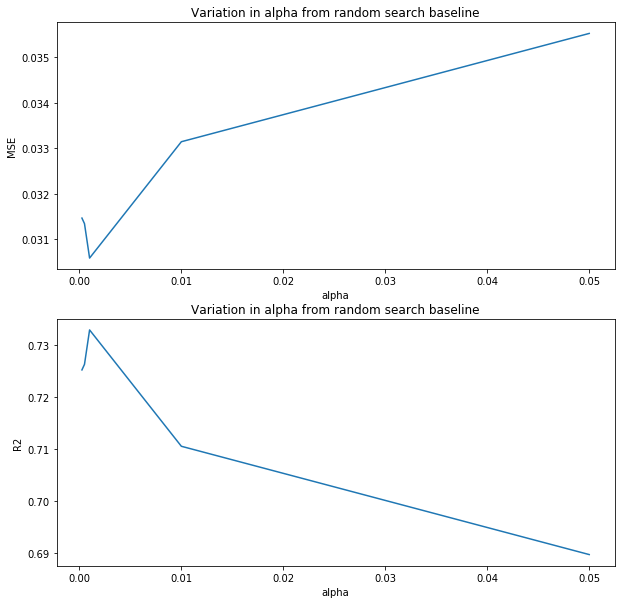

In [13]:
results5 = dictionaryLists(model_tuned, base_model = model_obj["alg"], parameter='alpha', increments=[0.25 , 0.5 ,1, 10, 50])
plot_paramtuned(results5, 'alpha' ,[0.25 , 0.5 ,1, 10, 50], metrics = ['MSE','R2'])

In [14]:
# with open("mlp_tune_1.txt", "wb") as fp:   #Pickling
#     pickle.dump(results, fp)
    
# with open("mlp_tune_3.txt", "wb") as fp:
#     pickle.dump(results3, fp)
    
# with open("mlp_tune_4.txt", "wb") as fp:
#     pickle.dump(results4, fp)

# with open("mlp_tune_5.txt", "wb") as fp:
#     pickle.dump(results5, fp)
    
results5

[{'Xs': 0.00025,
  'Ys': {'MSE': [0.03146478223474451],
   'MAE': [0.12500474030288347],
   'R2': [0.725130023187186],
   'Time': [102.40189695358276]}},
 {'Xs': 0.0005,
  'Ys': {'MSE': [0.03134279852592324],
   'MAE': [0.12450137214501111],
   'R2': [0.7261956482077279],
   'Time': [83.90394377708435]}},
 {'Xs': 0.001,
  'Ys': {'MSE': [0.030587310048213134],
   'MAE': [0.12317100512494876],
   'R2': [0.7327954428225851],
   'Time': [41.245813608169556]}},
 {'Xs': 0.01,
  'Ys': {'MSE': [0.03314167374933603],
   'MAE': [0.12916892948912156],
   'R2': [0.7104810379091502],
   'Time': [30.650102853775024]}},
 {'Xs': 0.05,
  'Ys': {'MSE': [0.035519454448969624],
   'MAE': [0.1353883409543944],
   'R2': [0.6897092263994384],
   'Time': [40.050485610961914]}}]

### Appendix
----
Learning Curve:

Automatically created module for IPython interactive environment


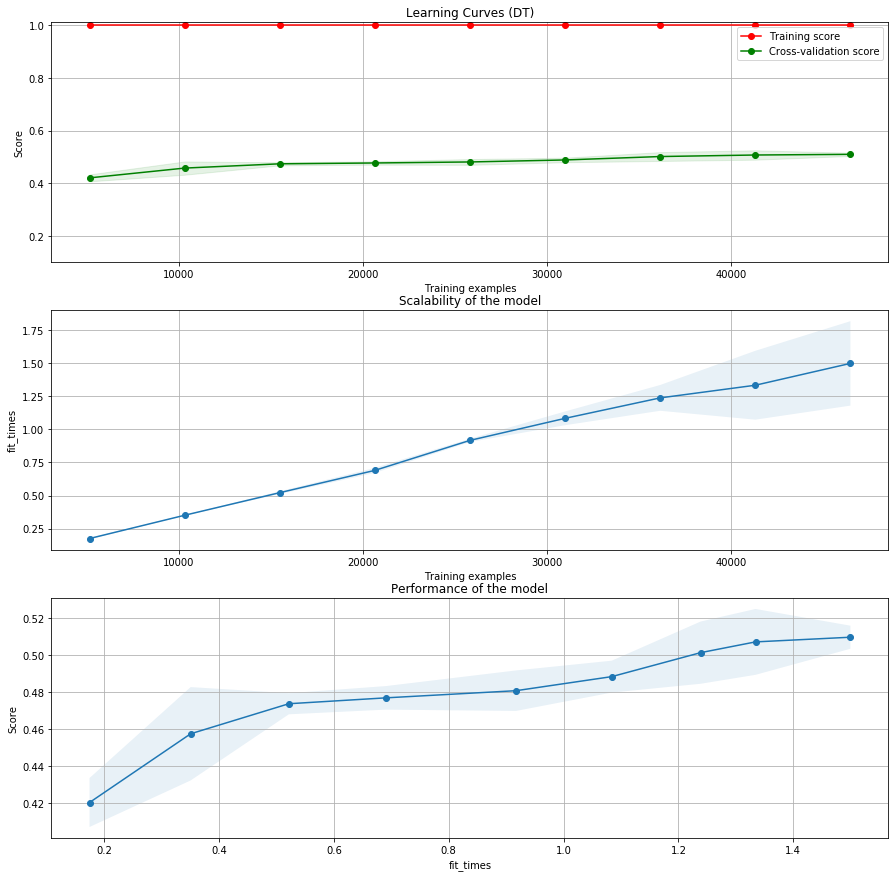

In [9]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
from sklearn.model_selection import ShuffleSplit, learning_curve


print(__doc__)

def plot_learning_curve(estimator, title, X,y ,axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(0.1,0.9,num=9)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X,y,cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

# read data
new_df = pd.read_csv('./processed_data/new_TRAIN_DF.csv')

# features
X = new_df.drop("price", axis=1).values

# label
y = new_df["price"].values
y = np.log10(y) # transform label

# model
estimator = model_obj["alg"]()

# cross-validation
cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=SEED)

# plot
fig, axes = plt.subplots(3,1 , figsize=(15, 15))
title = f"Learning Curves ({model_obj['name']})"

# learning curve
plot_learning_curve(estimator, title, X, y, axes=axes[:], ylim=(0.1, 1.01), cv=cv, n_jobs=WORKERS)
plt.show()